# Input Housing Starts Generation: GLM with PyMC3

In [6]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light?
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

import pymc
import statsmodels.api as sm

## Data import

In [8]:
# housing starts
p = 'data/starts_historic_canada_yearly.csv'
ca_starts_df = pd.read_csv(p, index_col=0)
# population
pop_cany_df = pd.read_csv('data/population_historic_canada_yearly.csv', index_col=0)
#gdp
gdp_cany_df = pd.read_csv('data/gdp_historic_canada_yearly.csv', index_col=0)
#cpi
cpi_cany_df = pd.read_csv('data/cpi_historic_canada_yearly.csv', index_col=0)

## Exploratory
Plot relationships: basic, check stationarity, check relationship after differencing (we know that starts is non-stationary)


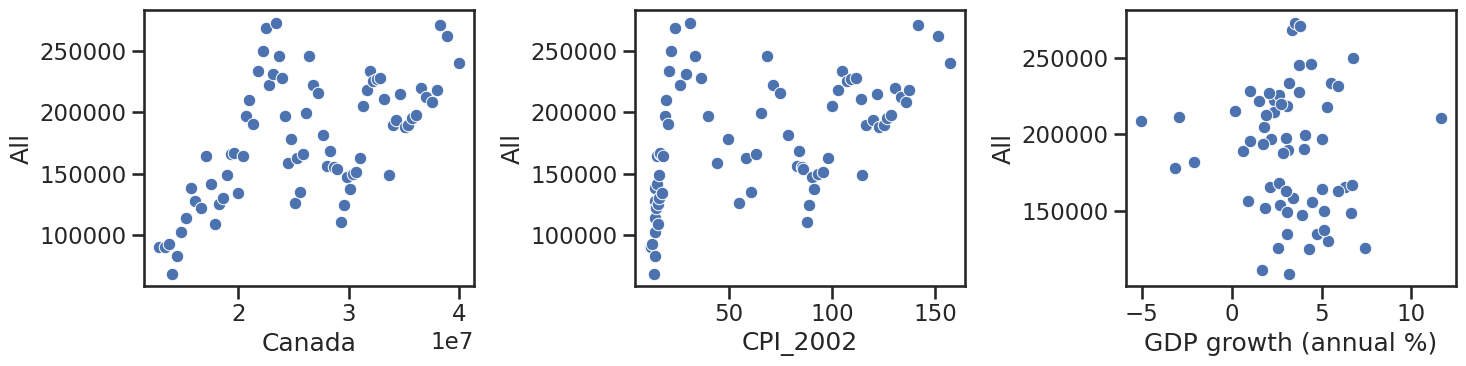

In [9]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
sns.scatterplot(x=pop_cany_df['Canada'], y=ca_starts_df['All'], ax=ax[0])
sns.scatterplot(x=cpi_cany_df['CPI_2002'], y=ca_starts_df['All'], ax=ax[1])
sns.scatterplot(x=gdp_cany_df['GDP growth (annual %)'], y=ca_starts_df['All'], ax=ax[2])

#ax[0].set_ylim([0,2*10**6])
#ax[0].set_xlim([0,0.5*10**8])

plt.tight_layout()

Autocorrelation

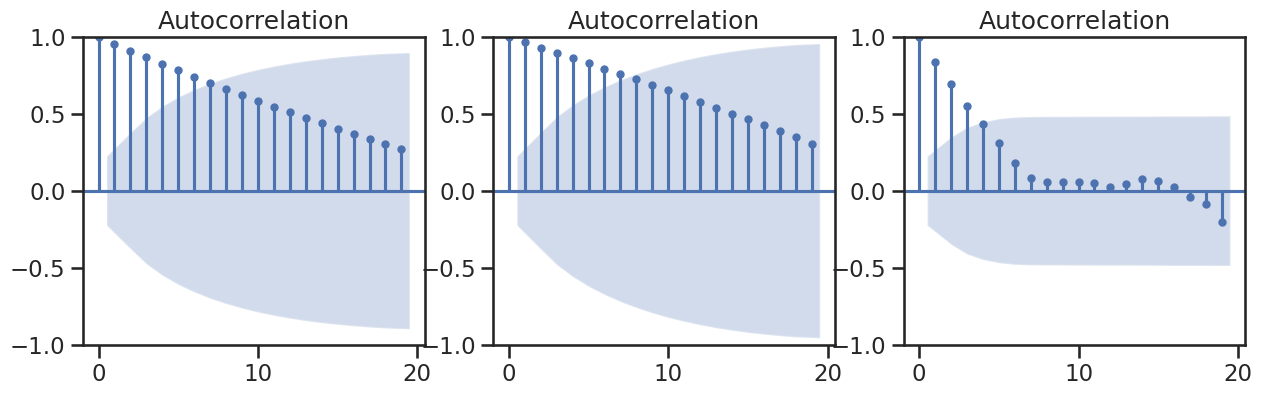

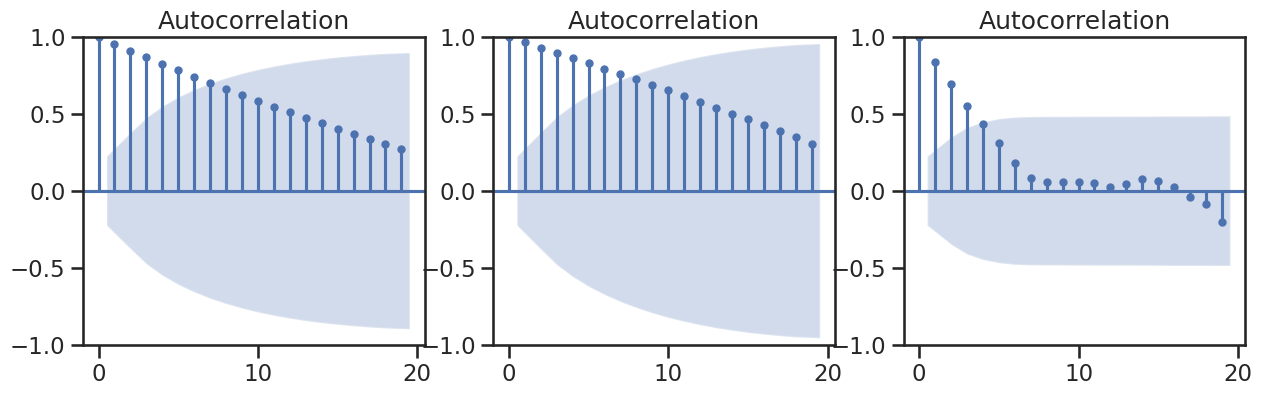

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
sm.graphics.tsa.plot_acf(pop_cany_df['Canada'], ax=ax[0])
sm.graphics.tsa.plot_acf(cpi_cany_df['CPI_2002'],ax=ax[1])
sm.graphics.tsa.plot_acf(ca_starts_df['All'], ax=ax[2])

Differencing

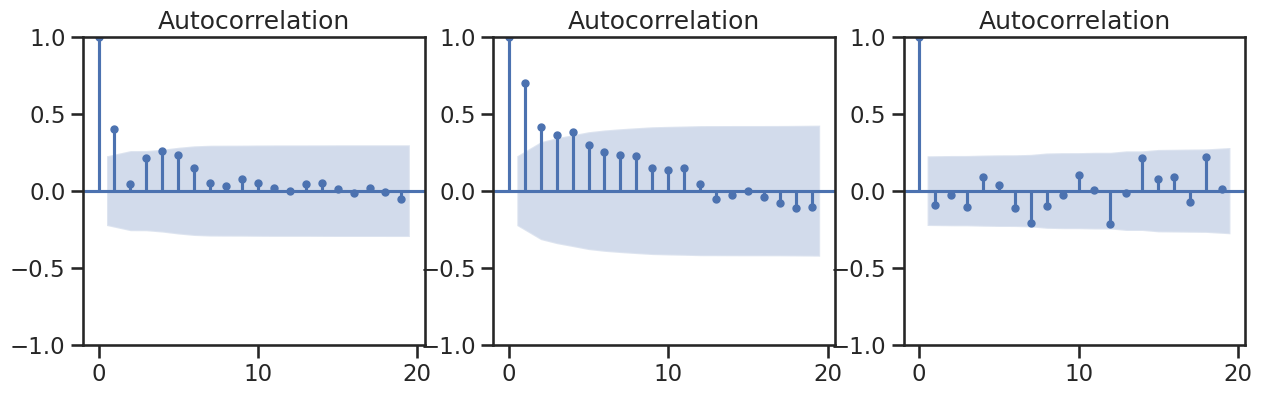

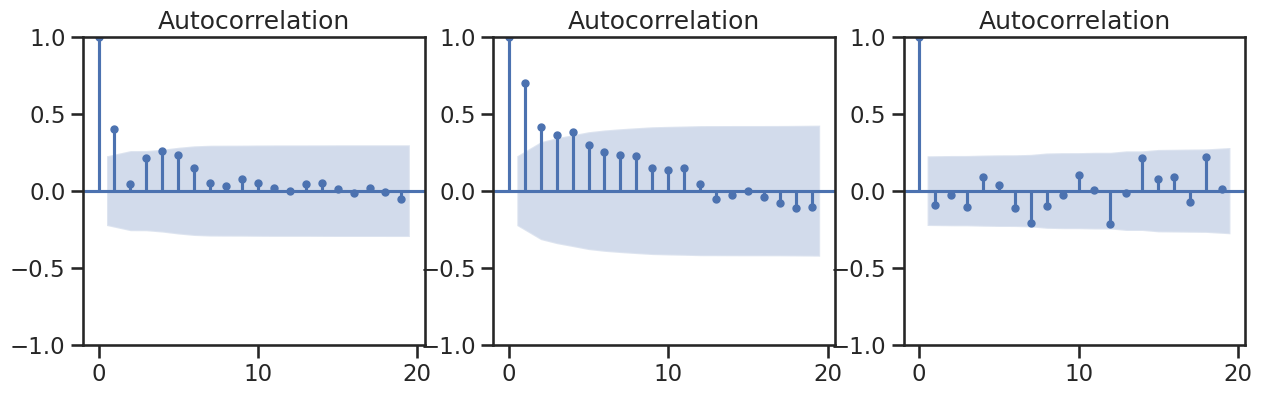

In [11]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
sm.graphics.tsa.plot_acf(pop_cany_df['Canada'].diff().dropna(), ax=ax[0])
sm.graphics.tsa.plot_acf(cpi_cany_df['CPI_2002'].diff().dropna(),ax=ax[1])
sm.graphics.tsa.plot_acf(ca_starts_df['All'].diff().dropna(), ax=ax[2])

Plot the differenced values agaisnt one another

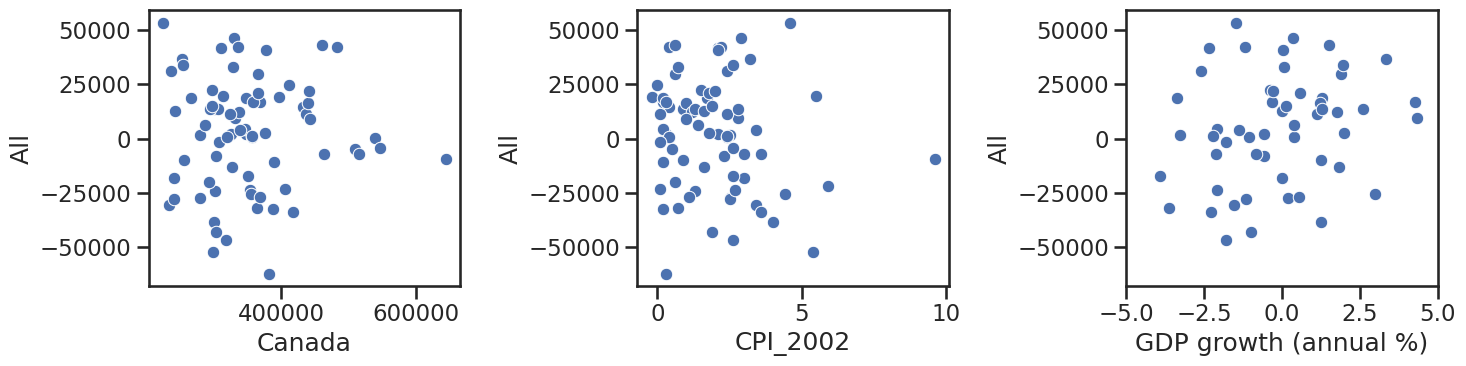

In [12]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
sns.scatterplot(x=pop_cany_df['Canada'].diff().loc[:2022], y=ca_starts_df['All'].diff().loc[:2022], ax=ax[0])
sns.scatterplot(x=cpi_cany_df['CPI_2002'].diff(), y=ca_starts_df['All'].diff(), ax=ax[1])
sns.scatterplot(x=gdp_cany_df['GDP growth (annual %)'].diff(), y=ca_starts_df['All'].diff(), ax=ax[2])

ax[2].set_xlim(-5,5)

plt.tight_layout()

Population is an easy variable to start with because we have the future prediction

## Bayesian modelling
simple linear bayesian model where H = housing starts, P = population: <br>
$$ H \sim N(P\beta,\sigma^2) $$

In [13]:
#PYMC3 packages
import arviz as az
import pymc as pm
import xarray as xr
from pymc import HalfCauchy, Model, Normal, Uniform, sample

rseed = 1612
rng = np.random.default_rng(rseed)

In [14]:
x = pop_cany_df['Canada'].values#.diff().loc[:2022].dropna().values
y = ca_starts_df['All'].values#.diff().loc[:2022].dropna().values

# sigma prior -> sqrt(n-1) is maximum of sigma/u
print(np.sqrt(75))
# set sigma to half cauchy with very high parameter (ends up giving about the same value)

8.660254037844387


In [15]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define uninformative priors
    sigma = HalfCauchy("sigma", beta=100)
    intercept = Uniform("intercept", lower=0, upper=200000)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

results

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


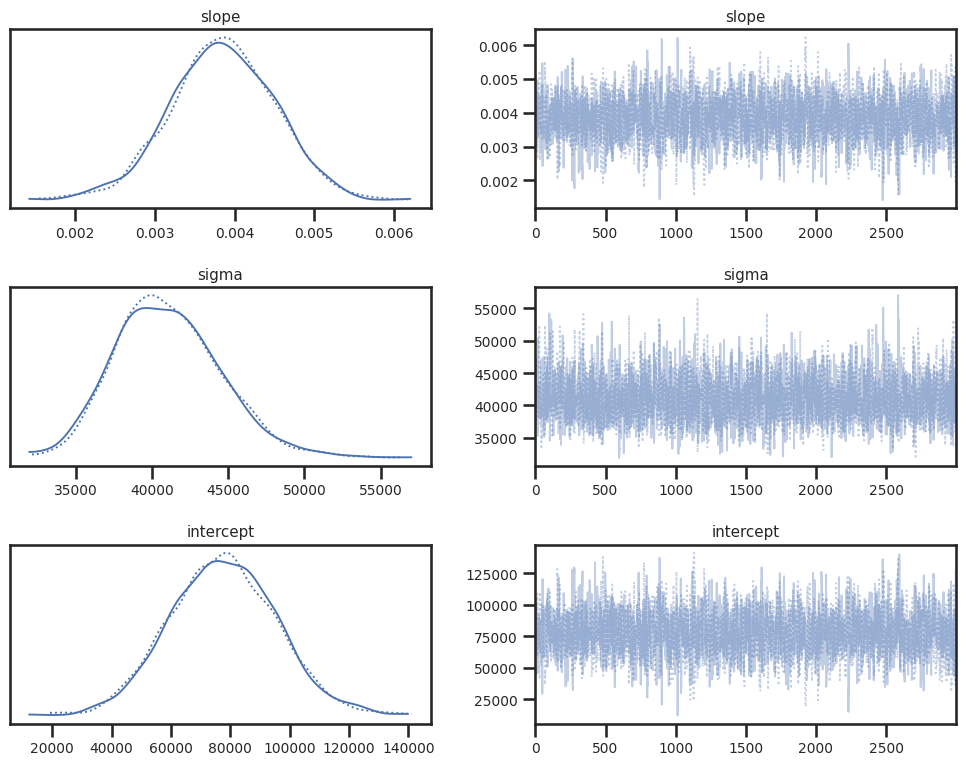

In [16]:
az.plot_trace(idata, figsize=(10, 8))
plt.tight_layout()
plt.savefig('bayesianGLU.png', bbox_inches='tight')

Sampling posterior

In [ ]:
idata.posterior["y_model"] = idata.posterior["intercept"] + idata.posterior["slope"] * xr.DataArray(x)

/usr/local/lib/python3.10/dist-packages/arviz/plots/lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


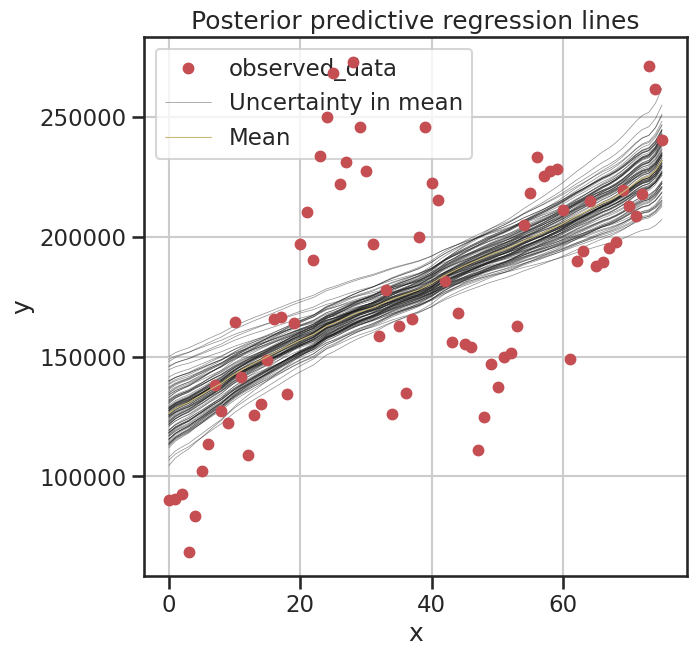

In [ ]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");

In [ ]:
idata.posterior

<xarray.Dataset>
Dimensions:    (chain: 2, draw: 3000, dim_0: 76)
Coordinates:
  * chain      (chain) int64 0 1
  * draw       (draw) int64 0 1 2 3 4 5 6 ... 2993 2994 2995 2996 2997 2998 2999
Dimensions without coordinates: dim_0
Data variables:
    slope      (chain, draw) float64 0.003123 0.004636 ... 0.004082 0.004397
    sigma      (chain, draw) float64 4.318e+04 3.831e+04 ... 3.802e+04 3.685e+04
    intercept  (chain, draw) float64 1.014e+05 5.773e+04 ... 7.13e+04 6.49e+04
    y_model    (chain, draw, dim_0) float64 1.415e+05 1.431e+05 ... 2.406e+05
Attributes:
    created_at:                 2024-04-06T23:09:47.185947
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              29.165351152420044
    tuning_steps:               1000

## Sample posterior
sample and store from the posterior of the parameters for the simple regression

<Axes: ylabel='Density'>

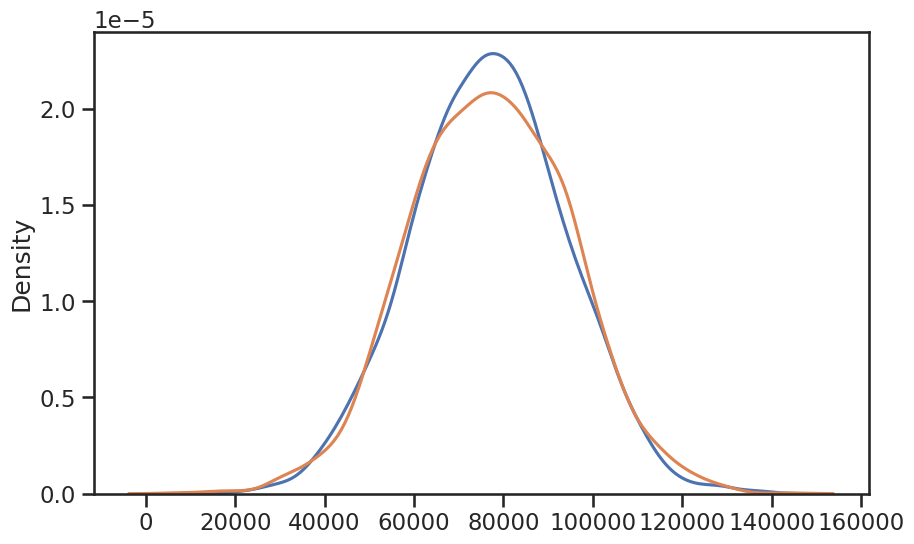

In [ ]:
foo = idata.posterior["intercept"][0]
foo2 = idata.posterior["intercept"][1]
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(foo, ax=ax)
sns.kdeplot(foo2, ax=ax)

In [ ]:
np.append(idata.posterior["intercept"][0],idata.posterior["intercept"][1])

array([68065.24854196, 74754.68281282, 67155.22541067, ...,
       54994.8857959 , 87495.9869643 , 93974.08025304])

## Export posterior samples

In [ ]:
posterior_samples_ph = pd.DataFrame(data=np.array([np.append(idata.posterior["intercept"][0],idata.posterior["intercept"][1]),
                                    np.append(idata.posterior["slope"][0],idata.posterior["slope"][1])]).T,
                                    columns=['intercept','slope'])

#posterior_samples_ph.to_csv('pop_housing_linear_posteriors.csv')

## Posterior predictive check

In [17]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


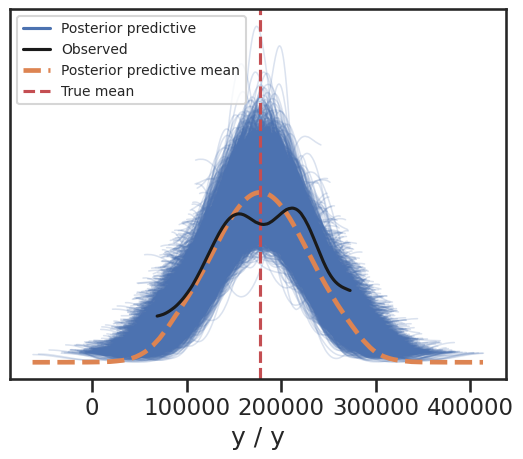

In [19]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(y.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10)